# Fire Detection with Computer Vision

Data was collected to train a model to distinguish between the images that contain fire (fire images) and regular images (non-fire images), so the whole problem was binary classification.

Data is divided into 2 folders, fireimages folder contains 755 outdoor-fire images some of them contains heavy smoke, the other one is non-fireimages which contain 244 nature images (eg: forest, tree, grass, river, people, foggy forest, lake, animal, road, and waterfall).

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2 #OpenCV
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.layers import Dense, Activation, Flatten, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Load Data

Data can be found at: https://www.kaggle.com/phylake1337/fire-dataset

In [2]:
#mount google drive to import dataset stored in the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## EDA

In [3]:
fire_images_path = r"/content/drive/MyDrive/fire_dataset/fire_images"
non_fire_images_path = r"/content/drive/MyDrive/fire_dataset/non_fire_images"

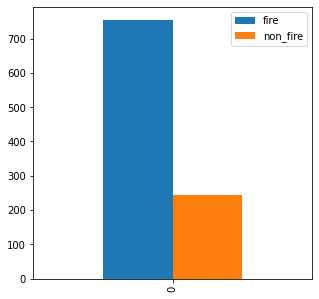

Count of Fire Images =  755
Count of Fire Images =  244


In [4]:
fire = len(os.listdir(fire_images_path))
non_fire = len(os.listdir(non_fire_images_path))

count = pd.DataFrame([[fire,non_fire]],columns=['fire','non_fire'])
count.plot(y=['fire','non_fire'], kind="bar", figsize=(5, 5))
plt.show()

print('Count of Fire Images = ', fire)
print('Count of Fire Images = ', non_fire)

### Visualize Data

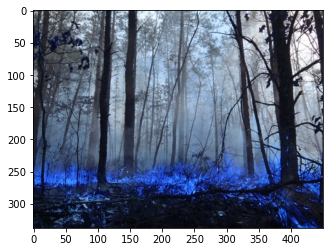

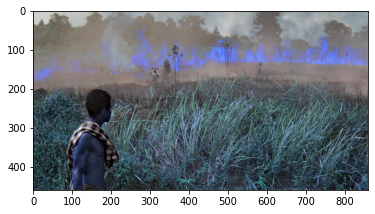

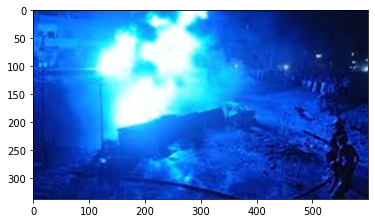

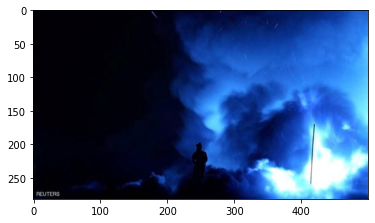

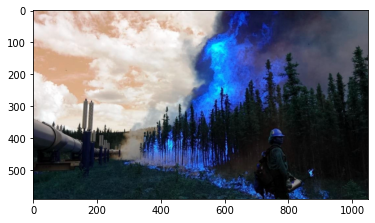

In [5]:
#Fire Images
for img in os.listdir(fire_images_path)[:5]:
  img_array = cv2.imread(os.path.join(fire_images_path,img))
  plt.imshow(img_array)
  plt.show()

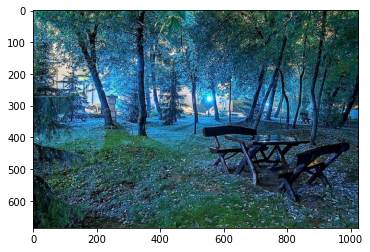

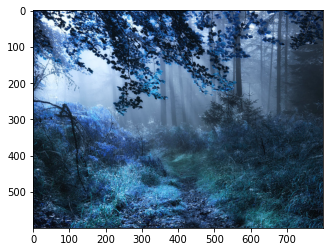

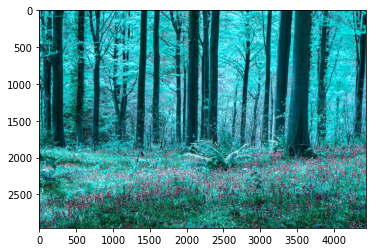

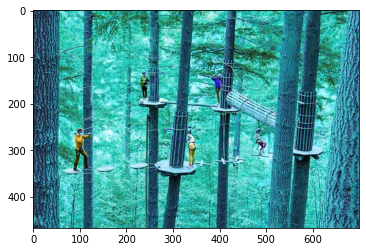

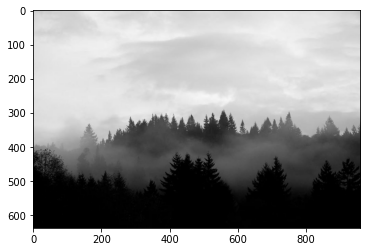

In [6]:
#Non-Fire Images
for img in os.listdir(non_fire_images_path)[:5]:
  img_array = cv2.imread(os.path.join(non_fire_images_path,img))
  plt.imshow(img_array)
  plt.show()

As we can see that the image shape and size are varying so we will try to standardize this

In [7]:
img_array.shape

(638, 960, 3)

In [8]:
data = []
IMG_SIZE = 300

def get_data(file_path,class_num, data):
    for img in os.listdir(file_path):
        try:
            img_array = cv2.imread(os.path.join(file_path,img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data.append([new_array, class_num])
        except:
            pass
get_data(fire_images_path,1,data)
get_data(non_fire_images_path,0,data)

We will apply some data augmentation so that the model performance can get enhanced via forming new and different examples to train datasets.

In [9]:
data_augmentation1 = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomZoom(0.5),
])

data_augmentation2 = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomContrast(0.2)
])

def apply_augmentation(data):
    for i in range(len(data)):
        if data[i][1] == 0:
            data.append([data_augmentation1(data[i][0]),0])
            data.append([data_augmentation2(data[i][0]),0])
apply_augmentation(data)
len(data)

1484

In [10]:
random.shuffle(data)

In [11]:
X = []
y = []

for i in data:
    X.append(i[0])
    y.append(i[1])

In [12]:
X = np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE,3)
y = np.array(y)

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1187, 300, 300, 3)
(148, 300, 300, 3)
(149, 300, 300, 3)


## Model Building

We will use tensorflow and keras to build a simple CNN with the layers required

In [15]:
model = models.Sequential([
    
  layers.Conv2D(32, kernel_size = (3,3), padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

    
  layers.Flatten(),
  layers.Dense(60, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 64)      

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
38/38 [==============================] - 21s 224ms/step - loss: 2.6456 - accuracy: 0.7473 - val_loss: 0.2462 - val_accuracy: 0.9060
Epoch 2/20
38/38 [==============================] - 7s 179ms/step - loss: 0.2189 - accuracy: 0.9250 - val_loss: 0.2771 - val_accuracy: 0.9060
Epoch 3/20
38/38 [==============================] - 7s 179ms/step - loss: 0.1568 - accuracy: 0.9402 - val_loss: 0.1795 - val_accuracy: 0.9195
Epoch 4/20
38/38 [==============================] - 7s 180ms/step - loss: 0.1556 - accuracy: 0.9427 - val_loss: 0.1989 - val_accuracy: 0.9128
Epoch 5/20
38/38 [==============================] - 7s 179ms/step - loss: 0.0984 - accuracy: 0.9621 - val_loss: 0.1763 - val_accuracy: 0.9329
Epoch 6/20
38/38 [==============================] - 7s 179ms/step - loss: 0.0964 - accuracy: 0.9638 - val_loss: 0.1807 - val_accuracy: 0.9396
Epoch 7/20
38/38 [==============================] - 7s 180ms/step - loss: 0.0986 - accuracy: 0.9663 - val_loss: 0.2910 - val_accuracy: 0.9195
Epoch

## Prediction & Evaluation


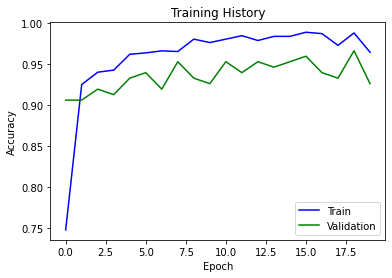

In [19]:
#visualize the training vs the validation accuracy of the model
plt.plot(history.history['accuracy'], c="b")
plt.plot(history.history['val_accuracy'], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [20]:
model.evaluate(X_test,y_test)

5/5 [==============================] - 1s 263ms/step - loss: 0.1171 - accuracy: 0.9662


[0.11705563217401505, 0.9662162065505981]

In [30]:
predictions = model.predict(X_test)

In [29]:
predicted= []
for i in predictions:
    if i >0.5:
        predicted.append(1)
    else:
        predicted.append(0)
predicted[:5]

[1, 0, 1, 1, 1]

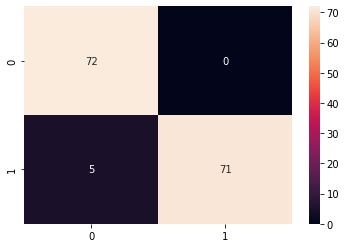

In [31]:
cm = tf.math.confusion_matrix(labels=y_test,predictions=predicted)
sns.heatmap(cm,annot=True, fmt='d')

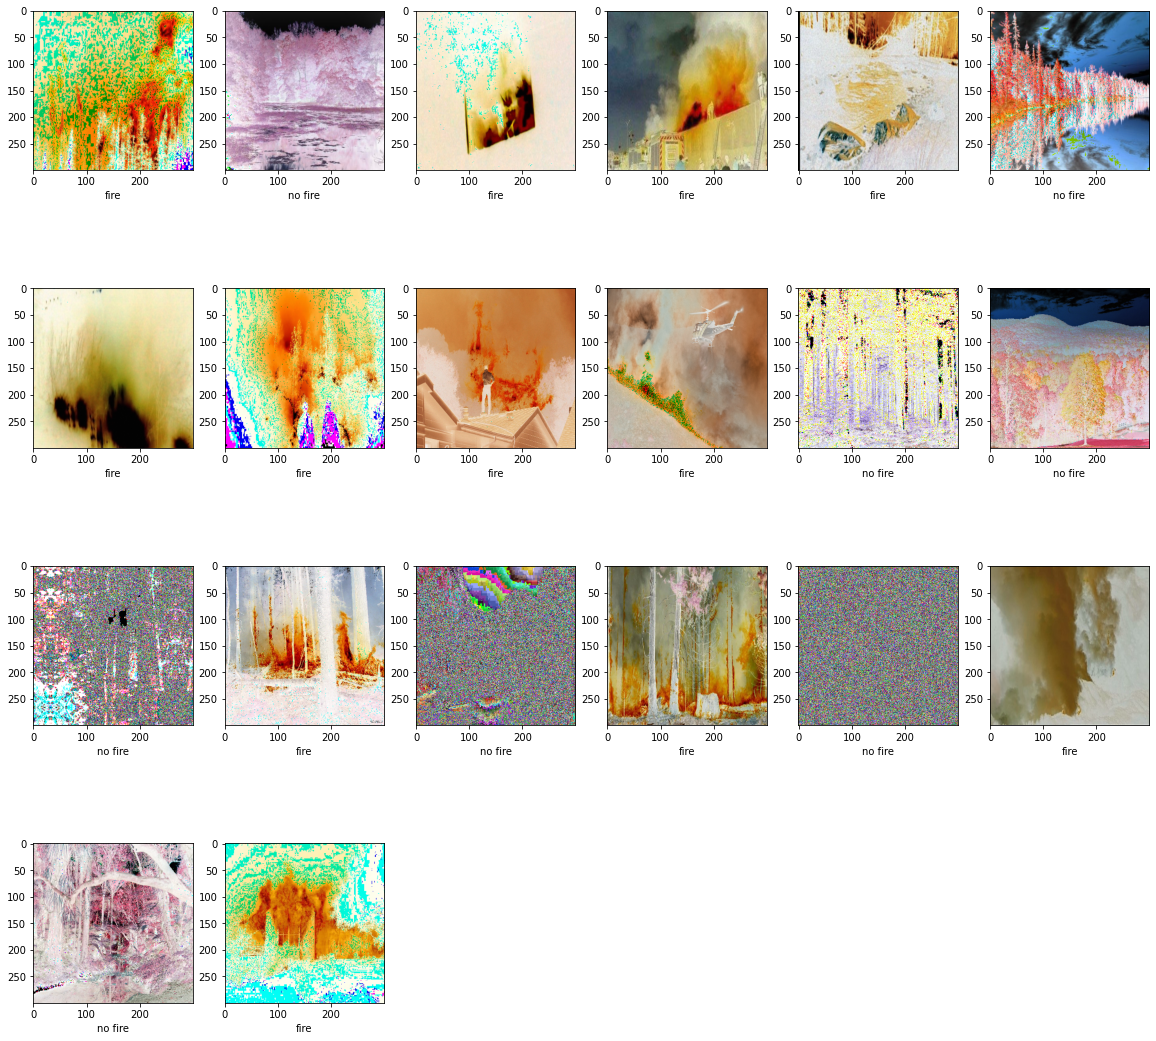

In [32]:
plt.figure(figsize=(20,40))

cat = ["no fire", "fire"]

for i in range(20):
    plt.subplot(8,6,i+1)
    plt.imshow((X_test[i] * 255).astype(np.uint8))
    plt.xlabel(cat[predicted[i]])